In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [2]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose, Flatten, Reshape, LeakyReLU
from tensorflow.keras.models import Sequential

2025-04-12 20:06:43.768730: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-12 20:06:43.786067: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-12 20:06:43.805462: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-12 20:06:43.811329: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-12 20:06:43.826777: I tensorflow/core/platform/cpu_feature_guar

In [5]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.config

Num GPUs Available:  1


<module 'tensorflow._api.v2.config' from '/opt/anaconda3/envs/deep_learning/lib/python3.12/site-packages/tensorflow/_api/v2/config/__init__.py'>

In [6]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [7]:
tf.random.set_seed(42)
np.random.seed(42)

### Figure processing

In [8]:
from PIL import Image
import numpy as np

In [9]:
def load_images(directory, max_images=None):
    images = []
    for filename in os.listdir(directory):
        if max_images and len(images) >= max_images:
            break
        if filename.endswith('.jpg'):
            img = Image.open(os.path.join(directory, filename))
            img = np.array(img)
            images.append(img)
    return np.array(images)

loading the dataset

In [ ]:
base_path = '自己的'

In [11]:
x_train_real = load_images(os.path.join(base_path, 'train/REAL/'), max_images=50000)
x_train_fake = load_images(os.path.join(base_path, 'train/FAKE/'), max_images=50000)

x_test_real = load_images(os.path.join(base_path, 'test/REAL/'), max_images=10000)
x_test_fake = load_images(os.path.join(base_path, 'test/FAKE/'), max_images=10000)

In [12]:
print("x_train_real shape:", x_train_real.shape)
print("x_train_fake shape:", x_train_fake.shape)
print("x_test_real shape:", x_test_real.shape)
print("x_test_fake shape:", x_test_fake.shape)

x_train_real shape: (50000, 32, 32, 3)
x_train_fake shape: (50000, 32, 32, 3)
x_test_real shape: (10000, 32, 32, 3)
x_test_fake shape: (10000, 32, 32, 3)


Combine together

In [13]:
# train_data 
y_train_real = np.zeros(50000)  # real=0
y_train_fake = np.ones(50000)   # fake=1
y_train = np.concatenate([y_train_real, y_train_fake])  # (100000,)

# test_data
y_test_real = np.zeros(10000)
y_test_fake = np.ones(10000)
y_test = np.concatenate([y_test_real, y_test_fake])

In [14]:
x_train = np.concatenate([x_train_real, x_train_fake])  # (100000, 32, 32, 3)
x_test = np.concatenate([x_test_real, x_test_fake])

In [15]:
#normalization
x_train = x_train / 255.0
x_test = x_test / 255.0

In [16]:
print("x_train shape:", x_train.shape)  
print("y_train shape:", y_train.shape)

x_train shape: (100000, 32, 32, 3)
y_train shape: (100000,)


Data enhancement

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [18]:
datagen = ImageDataGenerator(
    horizontal_flip=True,
    rotation_range=10,
    zoom_range=0.1
)
datagen.fit(x_train)

### SimCLR training (hidden labels)

enhance the picture


In [ ]:
def simclr_augmentation(image, apply_all=False):
    image = tf.cast(image, tf.float32)  # mare sure ->float32
    orig_image = image

    # (b) Crop and resize
    if apply_all or tf.random.uniform(()) < 0.5:
        regions = tf.constant([(0, 0, 20, 20), (12, 0, 20, 20), (0, 12, 20, 20), (12, 12, 20, 20)], dtype=tf.int32)
        idx = tf.random.uniform((), 0, 4, dtype=tf.int32)
        if apply_all:
            idx = 0
        region = tf.gather(regions, idx)
        x, y, h, w = region[0], region[1], region[2], region[3]
        if apply_all:
            x, y, h, w = int(x), int(y), int(h), int(w)
        image = tf.image.crop_to_bounding_box(image, y, x, h, w)
        image = tf.image.resize(image, [32, 32])
    crop_resize_image = image

    # (c) Crop, resize (and flip)
    if apply_all or tf.random.uniform(()) < 0.5:
        image = tf.image.random_flip_left_right(image)
    flip_image = image

    # (d) Color distort. (drop)
    if apply_all or tf.random.uniform(()) < 0.1:
        image = tf.image.rgb_to_grayscale(image)
        image = tf.tile(image, [1, 1, 3])
    color_drop_image = image

    # (e) Color distort. (jitter)
    if apply_all or tf.random.uniform(()) < 0.5:
        image = tf.image.random_brightness(image, max_delta=0.2)
        image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
        image = tf.image.random_hue(image, max_delta=0.1)
        image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    color_jitter_image = image

    # (f) Rotate {90°, 180°, 270°}
    if apply_all or tf.random.uniform(()) < 0.3:
        k = tf.random.uniform((), 1, 4, dtype=tf.int32)
        if apply_all:
            k = 1
        image = tf.image.rot90(image, k=k)
    rotate_image = image

    # (g) Cutout（修正：使用 tf.meshgrid 生成正確的 indices）
    if apply_all or tf.random.uniform(()) < 0.2:
        mask_size = 8
        offset = tf.random.uniform([2], 0, 32 - mask_size, dtype=tf.int32)
        x_indices, y_indices = tf.meshgrid(tf.range(mask_size), tf.range(mask_size), indexing='ij')
        x_indices = x_indices + offset[0]
        y_indices = y_indices + offset[1]
        indices = tf.stack([tf.reshape(x_indices, [-1]), tf.reshape(y_indices, [-1])], axis=-1)
        image = tf.tensor_scatter_nd_update(
            image, indices, tf.zeros([mask_size * mask_size, 3])
        )
    cutout_image = image

    # (h) Gaussian noise
    if apply_all or tf.random.uniform(()) < 0.2:
        noise = tf.random.normal([32, 32, 3], mean=0.0, stddev=0.1)
        image = image + noise
    gaussian_noise_image = image

    # (i) Gaussian blur
    if apply_all or tf.random.uniform(()) < 0.2:
        image = tf.nn.avg_pool2d(image[None, ...], ksize=3, strides=1, padding='SAME')[0]
    gaussian_blur_image = image

    image = tf.clip_by_value(image, 0.0, 1.0)

    if apply_all:
        return [
            orig_image, crop_resize_image, flip_image, color_drop_image,
            color_jitter_image, rotate_image, cutout_image, gaussian_noise_image,
            gaussian_blur_image
        ]
    return image

In [ ]:
def simclr_augmentation_batch(images):
    return tf.map_fn(lambda img: simclr_augmentation(img, apply_all=False), images, dtype=tf.float32)

loss comparison

In [ ]:
def simclr_loss(features1, features2, temperature=0.5):
    batch_size = tf.shape(features1)[0]
    features1 = tf.nn.l2_normalize(features1, axis=1)
    features2 = tf.nn.l2_normalize(features2, axis=1)
    similarity = tf.matmul(features1, features2, transpose_b=True)
    similarity /= temperature
    labels = tf.range(batch_size)
    loss = tf.keras.losses.sparse_categorical_crossentropy(labels, similarity, from_logits=True)
    return tf.reduce_mean(loss)

feature extration

In [ ]:
base_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128)
])

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

@tf.function
def train_step(images):
    aug1 = simclr_augmentation_batch(images)
    aug2 = simclr_augmentation_batch(images)
    with tf.GradientTape() as tape:
        features1 = base_model(aug1, training=True)
        features2 = base_model(aug2, training=True)
        loss = simclr_loss(features1, features2)
    gradients = tape.gradient(loss, base_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, base_model.trainable_variables))
    return loss

Data Set

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(10000).batch(128).prefetch(tf.data.AUTOTUNE)

In [ ]:
def visualize_all_augmentations(image):
    augmented_images = simclr_augmentation(image, apply_all=True)
    titles = [
        "(a) Original", "(b) Crop and resize", "(c) Crop, resize (and flip)",
        "(d) Color distort. (drop)", "(e) Color distort. (jitter)",
        "(f) Rotate {90°, 180°, 270°}", "(g) Cutout", "(h) Gaussian noise",
        "(i) Gaussian blur"
    ]
    plt.figure(figsize=(15, 5), dpi=100)
    for i in range(9):
        plt.subplot(2, 5, i + 1)
        plt.imshow(augmented_images[i].numpy())
        plt.title(titles[i], fontsize=10)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
visualize_all_augmentations(x_train[0])

Training SimCLR

In [ ]:
epochs = 20
losses = []
for epoch in range(epochs):
    total_loss = 0
    for images in train_dataset:
        loss = train_step(images)
        total_loss += loss
    avg_loss = total_loss / len(train_dataset)
    losses.append(avg_loss)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, epochs + 1), losses, marker='o')
plt.title("SimCLR Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

Save the model

In [ ]:
base_model.save('simclr_base_model.h5')
print("SimCLR base model saved to 'simclr_base_model.h5'")

### Method 1: Logic Regression for Real/Fake Classification

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

loading the model

In [46]:
base_model = tf.keras.models.load_model('/home/shukylaw8/myproject/env/SDSC4008/idea_flow_CNN/simclr_base_model.h5')
print("SimCLR base model loaded from 'simclr_base_model.h5'")

SimCLR base model loaded from 'simclr_base_model.h5'


In [47]:
def extract_features(model, dataset):
    features = []
    labels = []
    for images, lbls in dataset:
        feats = model(images, training=False)
        features.append(feats.numpy())
        labels.append(lbls.numpy())
    return np.concatenate(features), np.concatenate(labels)

In [48]:
train_dataset_with_labels = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(128).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(128).prefetch(tf.data.AUTOTUNE)

In [49]:
print("\nMethod 1: Logistic Regression for Real/Fake Classification")
train_features, train_labels = extract_features(base_model, train_dataset_with_labels)
test_features, test_labels = extract_features(base_model, test_dataset)

clf = LogisticRegression(max_iter=1000)
clf.fit(train_features, train_labels)
test_probs_lr = clf.predict_proba(test_features)  
test_preds_lr = clf.predict(test_features)
accuracy_lr = accuracy_score(test_labels, test_preds_lr)
print(f"Logistic Regression Accuracy: {accuracy_lr:.4f}")


Method 1: Logistic Regression for Real/Fake Classification
Logistic Regression Accuracy: 0.6840


/opt/anaconda3/envs/deep_learning/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Method 2 : Fine-tuning SimCLR Model for Real/Fake Classification

In [50]:
for layer in base_model.layers[:-1]: 
    layer.trainable = False

In [51]:
classification_model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Dense(1, activation='sigmoid') 
])

In [52]:
classification_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  #which to use the smaller learning rate
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [53]:
fine_tune_epochs = 10
history = classification_model.fit(
    train_dataset_with_labels,
    epochs=fine_tune_epochs,
    validation_data=test_dataset
)

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9613 - loss: 0.1384 - val_accuracy: 0.5000 - val_loss: 8.1961
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8977 - loss: 1.0265 - val_accuracy: 0.5000 - val_loss: 5.8878
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.8747 - loss: 0.8514 - val_accuracy: 0.5000 - val_loss: 5.1731
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8632 - loss: 0.7787 - val_accuracy: 0.5000 - val_loss: 5.2792
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8675 - loss: 0.7862 - val_accuracy: 0.5000 - val_loss: 4.3798
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8762 - loss: 0.6417 - val_accuracy: 0.5000 - val_loss: 4.6194
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.8720 - loss: 0.6630 - val_accuracy: 0.5000 - val_loss: 4.8968
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8800 - loss: 0.6731 - val_accuracy: 0

In [54]:
test_images_list = []
test_labels_list = []
test_probs_list = []
for images, labels in test_dataset:
    probs = classification_model.predict(images, verbose=0)
    test_images_list.append(images.numpy())
    test_labels_list.append(labels.numpy())
    test_probs_list.append(probs)

test_images = np.concatenate(test_images_list)
test_labels = np.concatenate(test_labels_list)
test_probs_finetune = np.concatenate(test_probs_list)

test_preds_finetune = (test_probs_finetune > 0.5).astype(int)
accuracy_finetune = accuracy_score(test_labels, test_preds_finetune)
print(f"Final Test Accuracy (Fine-tuning): {accuracy_finetune:.4f}")

2025-04-12 20:21:43.750531: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Final Test Accuracy (Fine-tuning): 0.5000


In [55]:
np.random.seed(42)  
sample_indices = np.random.choice(len(test_images), 10, replace=False)
sample_images = test_images[sample_indices]
sample_labels = test_labels[sample_indices]
sample_probs_lr = test_probs_lr[sample_indices]
sample_probs_finetune = test_probs_finetune[sample_indices]

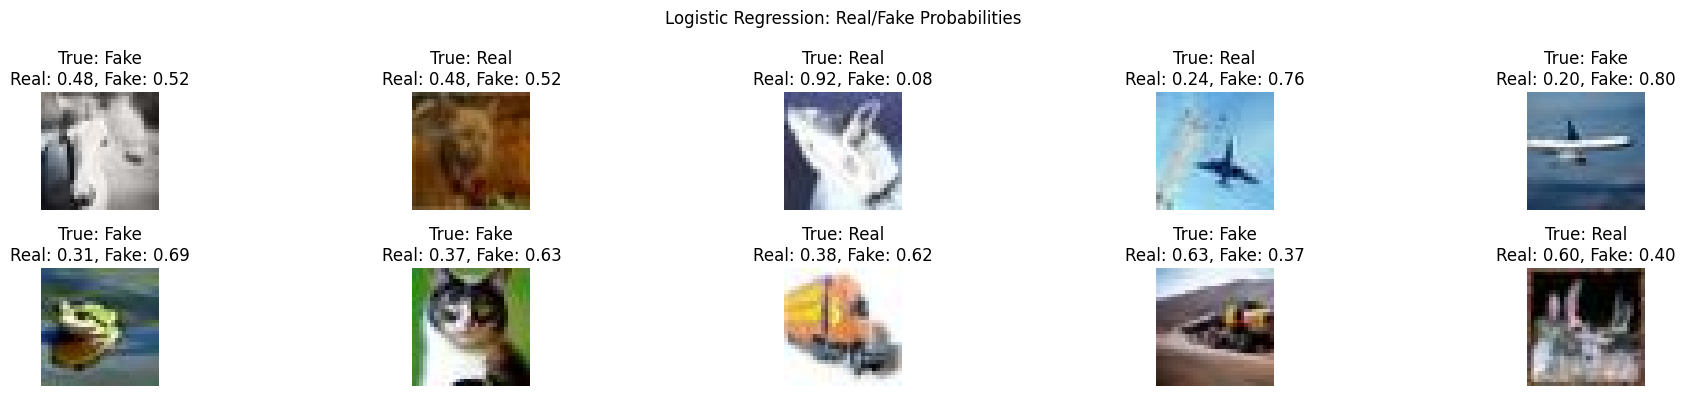

In [56]:
#Data Visualization (LR)
plt.figure(figsize=(20, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(sample_images[i])
    plt.title(f"True: {'Real' if sample_labels[i] == 0 else 'Fake'}\nReal: {sample_probs_lr[i][0]:.2f}, Fake: {sample_probs_lr[i][1]:.2f}")
    plt.axis('off')
plt.suptitle("Logistic Regression: Real/Fake Probabilities")
plt.tight_layout()
plt.show()

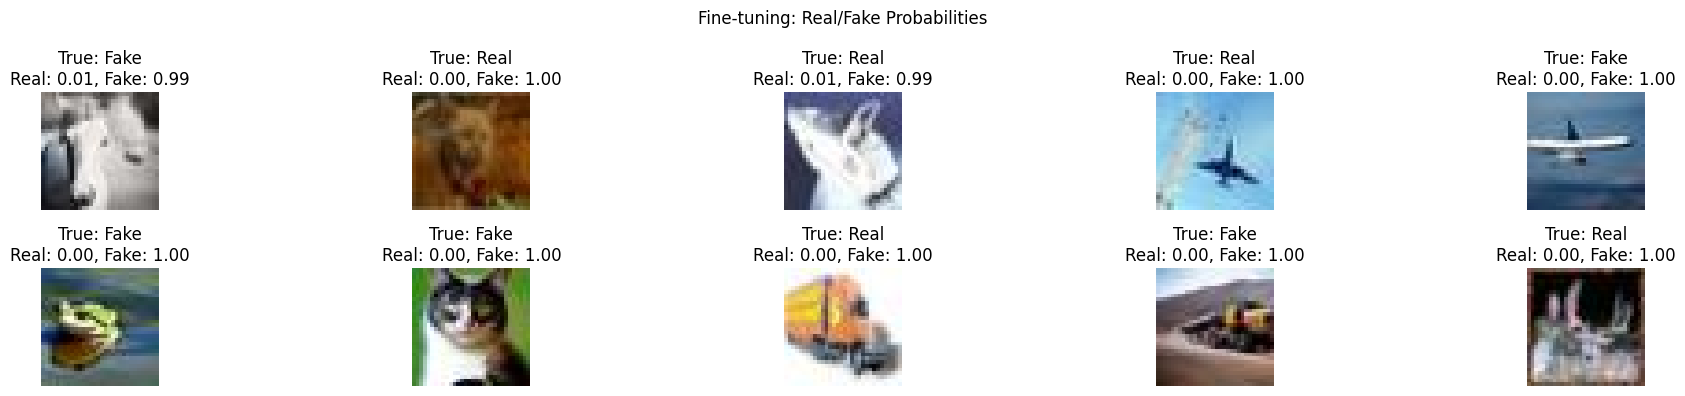

In [ ]:
#Data Visualization (Fine-tune)
plt.figure(figsize=(20, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(sample_images[i])
    plt.title(f"True: {'Real' if sample_labels[i] == 0 else 'Fake'}\nReal: {1 - sample_probs_finetune[i][0]:.2f}, Fake: {sample_probs_finetune[i][0]:.2f}")
    plt.axis('off')
plt.suptitle("Fine-tuning: Real/Fake Probabilities")
plt.tight_layout()
plt.show()

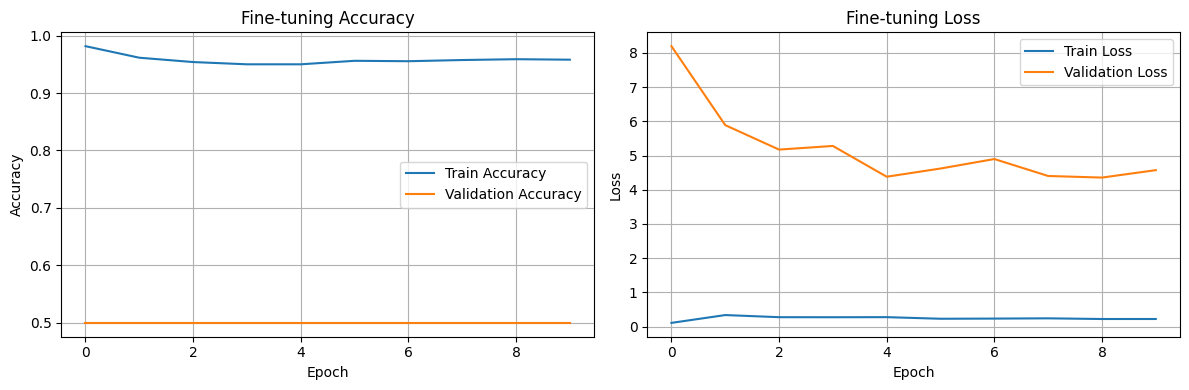

In [57]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Fine-tuning Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Fine-tuning Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Data Visualization

In [ ]:
def plot_images(real_images, fake_images, num_samples=5):
    plt.figure(figsize=(10, 4))
    for i in range(num_samples):
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(real_images[i])
        plt.title("Real")
        plt.axis("off")
        plt.subplot(2, num_samples, i + num_samples + 1)
        plt.imshow(fake_images[i])
        plt.title("Fake")
        plt.axis("off")
    plt.show()

plot_images(x_train_real, x_train_fake)

In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def plot_images(real_images, fake_images, real_labels, fake_labels, num_samples=5):
    plt.figure(figsize=(12, 5), dpi=100)
    for i in range(num_samples):
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(real_images[i])
        label = int(real_labels[i])
        title = f"Real: {class_names[label]}" if label != -1 else "Real: Unknown"
        plt.title(title, fontsize=10)
        plt.axis("off")
        plt.subplot(2, num_samples, i + num_samples + 1)
        plt.imshow(fake_images[i])
        label = int(fake_labels[i])
        title = f"Fake: {class_names[label]}" if label != -1 else "Fake: Unknown"
        plt.title(title, fontsize=10)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

plot_images(x_train_real, x_train_fake, y_train_real, y_train_fake)

In [ ]:
def plot_pixel_distribution(real_images, fake_images):
    plt.figure(figsize=(12, 4))
    for i, color in enumerate(['Red', 'Green', 'Blue']):
        plt.subplot(1, 3, i + 1)
        plt.hist(real_images[:, :, :, i].ravel(), bins=50, alpha=0.5, label='Real', color='blue')
        plt.hist(fake_images[:, :, :, i].ravel(), bins=50, alpha=0.5, label='Fake', color='red')
        plt.title(f"{color} Channel")
        plt.legend()
    plt.show()

plot_pixel_distribution(x_train_real, x_train_fake)

In [ ]:
def plot_brightness_distribution(real_images, fake_images):
    real_brightness = 0.299 * real_images[:, :, :, 0] + 0.587 * real_images[:, :, :, 1] + 0.114 * real_images[:, :, :, 2]
    fake_brightness = 0.299 * fake_images[:, :, :, 0] + 0.587 * fake_images[:, :, :, 1] + 0.114 * fake_images[:, :, :, 2]
    plt.figure(figsize=(8, 4))
    plt.hist(real_brightness.ravel(), bins=50, alpha=0.5, label='Real', color='blue')
    plt.hist(fake_brightness.ravel(), bins=50, alpha=0.5, label='Fake', color='red')
    plt.title("Brightness Distribution")
    plt.xlabel("Brightness")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()
    
plot_brightness_distribution(x_train_real, x_train_fake)

In [ ]:
def plot_contrast_distribution(real_images, fake_images, num_samples=1000):
    real_contrast = np.std(real_images[:num_samples], axis=(1, 2, 3))
    fake_contrast = np.std(fake_images[:num_samples], axis=(1, 2, 3))
    plt.figure(figsize=(8, 4))
    plt.hist(real_contrast, bins=50, alpha=0.5, label='Real', color='blue')
    plt.hist(fake_contrast, bins=50, alpha=0.5, label='Fake', color='red')
    plt.title("Contrast Distribution")
    plt.xlabel("Contrast (Pixel Std)")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()
 
plot_contrast_distribution(x_train_real, x_train_fake)    

In [ ]:
from scipy.ndimage import sobel
def plot_edge_distribution(real_images, fake_images, num_samples=1):
    real_image = real_images[num_samples-1]
    fake_image = fake_images[num_samples-1]
    real_grayscale = np.mean(real_image, axis=-1)
    fake_grayscale = np.mean(fake_image, axis=-1)
    real_edges = np.abs(sobel(real_grayscale))
    fake_edges = np.abs(sobel(fake_grayscale))
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(real_edges, cmap='gray')
    plt.title("Edges of Real Image")
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(fake_edges, cmap='gray')
    plt.title("Edges of Fake Image")
    plt.axis('off')
    plt.show()

plot_edge_distribution(x_train_real, x_train_fake)

In [ ]:
def plot_tsne_features(real_images, fake_images, model, num_samples=1000):
    real_features = model.predict(real_images[:num_samples])
    fake_features = model.predict(fake_images[:num_samples])
    features = np.concatenate([real_features, fake_features])
    labels = np.concatenate([np.zeros(num_samples), np.ones(num_samples)])
    tsne = TSNE(n_components=2, random_state=42)
    embeddings = tsne.fit_transform(features)
    plt.figure(figsize=(8, 6))
    plt.scatter(embeddings[:num_samples, 0], embeddings[:num_samples, 1], c='blue', label='Real', alpha=0.5)
    plt.scatter(embeddings[num_samples:, 0], embeddings[num_samples:, 1], c='red', label='Fake', alpha=0.5)
    plt.title("t-SNE of SimCLR Features (Real vs Fake)")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.legend()
    plt.show()
    
plot_tsne_features(x_train_real, x_train_fake, base_model)

In [ ]:
pip install scikit-image

In [ ]:
from skimage.metrics import structural_similarity as ssim

In [ ]:
def plot_difference_map(real_images, fake_images, num_samples=1):
    real_image = real_images[num_samples-1]
    fake_image = fake_images[num_samples-1]
    diff = np.abs(real_image - fake_image)
    plt.figure(figsize=(15, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(real_image)
    plt.title("Real Image")
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(fake_image)
    plt.title("Fake Image")
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(diff)
    plt.title("Difference Map")
    plt.axis('off')
    plt.show()

In [ ]:
def plot_ssim_distribution(real_images, fake_images, num_samples=500):
    real_images = np.clip(real_images[:num_samples], 0, 1)
    fake_images = np.clip(fake_images[:num_samples], 0, 1)
    

    print("Real image shape:", real_images[0].shape)
    print("Fake image shape:", fake_images[0].shape)
    

    reference_image = real_images[0]  
    
    real_ssim = []
    fake_ssim = []
    for i in range(num_samples):
        ssim_real, _ = ssim(real_images[i], reference_image, multichannel=True, channel_axis=-1, full=True, win_size=3)
        real_ssim.append(ssim_real)
        ssim_fake, _ = ssim(fake_images[i], reference_image, multichannel=True, channel_axis=-1, full=True, win_size=3)
        fake_ssim.append(ssim_fake)
    
    plt.figure(figsize=(8, 4))
    plt.hist(real_ssim, bins=50, alpha=0.5, label='Real', color='blue')
    plt.hist(fake_ssim, bins=50, alpha=0.5, label='Fake', color='red')
    plt.title("SSIM Distribution (Compared to a Reference Real Image)")
    plt.xlabel("SSIM")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

In [ ]:
plot_difference_map(x_train_real, x_train_fake)
plot_ssim_distribution(x_train_real, x_train_fake)